Importing Libraries

In [2]:
import os
import cv2
import numpy as np
import torch
import webcolors
import torchvision
from tqdm import tqdm
import pandas as pd
from torchvision import transforms
from PIL import Image
from torchvision.transforms.functional import resize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter

DEEPLABV3 MODEL - COLOUR EXTRACTION

In [ ]:
# COLOURS = {
#     # --- Neutrals & Shadows (The 'Link' for backgrounds and lighting) ---
#     "Pure White": [255, 128, 128],
#     "Off-White/Cream": [245, 124, 140],
#     "Light Gray": [216, 128, 128],
#     "Medium Gray": [137, 128, 128],
#     "Shadow_Light": [177, 128, 128],  # Found in your logs near 138-170
#     "Shadow_Dark": [69, 128, 128],    # Found in your logs near 50-70
#     "Charcoal": [72, 125, 120],
#     "Black": [0, 128, 128],

#     # --- Skin Tones (Crucial to prevent mislabeling the person as clothes) ---
#     "Skin_Fair": [228, 134, 156],
#     "Skin_Tan": [191, 133, 152],
#     "Skin_Deep": [106, 147, 165],
#     "Skin_Dark": [52, 133, 135],

#     # --- Blues ---
#     "Navy Blue": [33, 175, 63],
#     "Royal Blue": [122, 154, 63],
#     "Sky Blue": [202, 113, 107],
#     "Light Blue": [214, 117, 117],
#     "Teal": [123, 99, 119],
#     "Turquoise": [207, 84, 124],

#     # --- Reds & Pinks ---
#     "Red": [136, 208, 195],
#     "Burgundy/Maroon": [65, 176, 166],
#     "Crimson": [120, 199, 162],
#     "Hot Pink": [167, 192, 117],
#     "Dusty Pink": [204, 141, 119],
#     "Light Pink": [207, 156, 133],
#     "Coral": [172, 173, 175],
#     "Peach": [228, 136, 149],

#     # --- Greens ---
#     "Emerald Green": [185, 77, 158],
#     "Forest Green": [129, 79, 173],
#     "Olive Green": [132, 115, 185],
#     "Mint Green": [234, 78, 168],
#     "Light Green": [221, 82, 165],
#     "Lime/Neon Green": [185, 61, 189],

#     # --- Yellows & Oranges ---
#     "Yellow": [248, 106, 223],
#     "Light Yellow": [253, 123, 143],
#     "Mustard Yellow": [225, 126, 195],
#     "Gold": [222, 126, 215],
#     "Orange": [191, 152, 207],
#     "Terracotta/Rust": [155, 170, 161],

#     # --- Purples ---
#     "Purple": [76, 187, 91],
#     "Lavender": [234, 132, 118],
#     "Plum": [104, 168, 106],
#     "Light Purple": [174, 148, 100],

#     # --- Browns & Earth Tones ---
#     "Chocolate Brown": [143, 165, 185],
#     "Tan/Sand": [191, 133, 152],
#     "Beige/Khaki": [245, 124, 140],
#     "Coffee": [92, 139, 147]
# }


# def get_colour_name(lab_pixel):
#     distances = {}
#     for colour, lab_value in COLOURS.items():
#         distance = np.linalg.norm(np.array(lab_pixel) - np.array(lab_value))
#         distances[colour] = distance
#     return min(distances, key=distances.get)

# def name_to_lab(colour_name):
#     if colour_name not in COLOURS:
#         print(f"Warning: '{colour_name}' not found in COLOURS dictionary. \nDefaulting to 'UNKNOWN COLOUR!'")
#     lab_val = np.uint8([[COLOURS.get(colour_name)]])
#     rgb_val = cv2.cvtColor(lab_val, cv2.COLOR_LAB2RGB)[0][0]
#     return rgb_val / 255.0

In [ ]:
# A broad, "Old-School" style dictionary with a Skin Trap
MAJOR_RGB_COLOURS = {
    "Red": [
        [200, 94, 79], [151, 72, 49], [232, 47, 69], [133, 33, 34],
        [244, 166, 123], [200, 0, 0], [82, 20, 23], [225, 32, 54],
        [139, 0, 0], [135, 15, 30], [200, 30, 54], [95, 33, 58],
        [135, 59, 79], [238, 21, 52], [192, 22, 49], [120, 38, 39],
        [215, 66, 83], [131, 50, 53], [169, 50, 57]
    ],

    "Orange": [
        [248, 143, 103], [227, 89, 75], [163, 36, 37], [213, 99, 75],
        [251, 145, 38], [207, 79, 16], [250, 158, 45], [213, 95, 29],
        [190, 126, 80], [195, 96, 61], [181, 59, 22], [245, 124, 54],
        [86, 39, 31], [255, 140, 0], [210, 120, 70], [181, 99, 79],
        [228, 129, 65], [160, 87, 61], [160, 71, 43]
    ],

    "Brown": [
        [103, 86, 68], [152, 122, 92], [101, 67, 33], [91, 69, 54],
        [78, 64, 58], [98, 86, 81], [165, 42, 42], [210, 105, 30],
        [70, 56, 47], [133, 83, 60]
    ],

    "Blue": [
        [9, 70, 101], [166, 220, 228], [73, 119, 180], [63, 97, 148],
        [20, 21, 32], [39, 40, 55], [0, 0, 200], [122, 131, 159],
        [21, 21, 34], [44, 56, 88], [22, 22, 35], [72, 99, 146],
        [40, 69, 116], [28, 32, 59], [134, 148, 179], [201, 211, 229],
        [79, 93, 120], [135, 150, 185], [91, 100, 124], [208, 218, 230],
        [108, 129, 164], [151, 174, 200], [60, 85, 122], [24, 23, 41],
        [23, 24, 40]],

    "Green": [[201, 214, 215], [32, 100, 96], [167, 185, 185], [128, 148, 143], [48, 185, 162], [64, 110, 101], [32, 48, 40], [132, 137, 127], [0, 200, 0], 
              [187, 226, 209], [140, 185, 185], [74, 85, 95], [105, 133, 138]],

    "Yellow": [[248, 200, 59], [211, 151, 52], [250, 220, 132], [220, 167, 55], [243, 190, 80], [201, 138, 43], [237, 185, 90], [255, 255, 0],
               [247, 179, 44], [249, 219, 158], [234, 168, 44], [240, 179, 70]],

    "Pink": [[244, 95, 130], [197, 34, 75], [212, 176, 176], [179, 131, 126], [241, 218, 220], [185, 152, 157], [225, 201, 205], [208, 176, 178],
              [158, 64, 135], [255, 100, 200], [234, 77, 68], [174, 106, 100], [174, 53, 69], [163, 83, 83], [212, 191, 200]],

    "White": [[235, 233, 235], [255, 255, 255], [240, 240, 246],[235, 232, 231], [220, 220, 224]],

    "Black": [[22, 20, 27], [0, 0, 0], [15, 15, 25], [15, 15, 24],[21, 21, 28], [23, 15, 19], [29, 23, 32], [28, 23, 24]],

    "Grey": [[112, 96, 100], [55, 56, 66], [71, 62, 69], [35, 33, 41], [169, 152, 154], [225, 223, 225], [117, 112, 114], [198, 195, 204], [94, 96, 117], 
             [123, 120, 139], [48, 37, 42], [74, 71, 87], [36, 30, 39], [216, 212, 221], [128, 128, 130], [107, 99, 103], [82, 83, 100], [35, 39, 49]],

    "Cream/Khaki/Beige": [[207, 164, 135], [244, 226, 198], [201, 157, 140], [216, 201, 193], [238, 227, 218], [196, 174, 162],[237, 201, 162], [197, 188, 198], [159, 135, 139], [200, 30, 54], 
                          [190, 154, 137], [196, 160, 143], [220, 205, 203], [216, 199, 199], [196, 136, 103], [196, 141, 106]],

    "Purple": [[30, 17, 23], [95, 35, 78], [31, 13, 27], [73, 57, 84], [36, 21, 32], [82, 71, 142], [50, 46, 88], [59, 39, 52]],
    
    # We label skin tones as "Skin" 
    # so we can delete them later.
    "Skin":
    [[23,16,18], [89, 57, 49], [72, 42, 36], [111, 84, 76], [26,26,43], [30,23,30], [31,22,20], [43,23,19], [44,30,43], [45,35,45], [51,32,24], [52,30,26], [55,31,31],[56,42,58], 
     [64,39,40], [66,41,50], [71,48,52], [76,44,38], [84,61,71], [94,60,62], [95,55,53], [101,57,56], [101,73,77], [101,75,67], [103,70,69], 
     [106,51,20], [107,68,65], [112,73,74], [113,95,108], [122,86,86], [128,100,97], [129,75,68], [129,79,79], [134,102,98], [147,96,90], 
     [150,138,147], [153,94,87], [154,126,139], [156,125,121], [159,113,95], [160,119,121], [162,108,102], [166,110,100], [177,132,129], 
     [182,122,112], [201,167,176], [204,161,148], [208,153,134], [214,163,156], [215,180,173], [230,179,168], [232,188,174], [233,198,190], 
     [233,211,212], [95, 63, 56], [77, 31, 21], [77, 25, 18]],

    "Highlights": [[67,65,86], [114,109,128], [126,111,127], [142,110,99], [146,124,123], [151,130,129], [159,135,145], [197,164,158], 
                   [208,142,106], [35, 34, 43], [72, 58, 61], [61, 52, 61], [168, 131, 123], [217,192,186], [142,149,184], [194, 185, 183]],
    
    "Shadows": [[23,16,18], [26,26,43], [30,23,30], [31,22,20], [43,23,19], [44,30,43], [52,30,26]],

    "BG": [[189,209,245], [179,203,240],[194,201,217], [105,106,120]]
}

In [4]:
# Convert the grouped RGB dictionary into flattened Lab values
FLAT_LAB_COLOURS = {}
for colour_name, rgb_list in MAJOR_RGB_COLOURS.items():
    for i, rgb in enumerate(rgb_list):
        # Convert the RGB pixel to Lab space matching OpenCV's scale
        rgb_pixel = np.uint8([[[rgb[0], rgb[1], rgb[2]]]])
        lab_pixel = cv2.cvtColor(rgb_pixel, cv2.COLOR_RGB2LAB)[0][0]
        
        # Save it with a unique index (e.g., "Red_0", "Red_1")
        FLAT_LAB_COLOURS[f"{colour_name}_{i}"] = lab_pixel

In [5]:
def get_colour_name(lab_pixel):
    distances = {name: np.linalg.norm(lab_pixel - val) for name, val in FLAT_LAB_COLOURS.items()}
    best_match = min(distances, key=distances.get)
    return best_match.split('_')[0]

In [6]:
import cv2
import numpy as np
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter # <-- We need this to count the pixels!

# 1. Load the model once
model_extractor = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights='DEFAULT').eval()
preprocess = transforms.Compose([
    transforms.Resize((520, 520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_and_show_palette2(image_path, n_colors=5):
    print(f"Analyzing {image_path.split('/')[-1]}...")
    
    # Load Image
    input_image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(input_image).unsqueeze(0)
    
    # Segment
    with torch.no_grad():
        mask = torch.argmax(model_extractor(input_tensor)['out'][0], dim=0).cpu().numpy()
        
    # Get pixels in LAB space 
    img_np = np.array(input_image.resize((520, 520)))
    img_lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    pixels_lab = img_lab[mask == 15]
    
    if len(pixels_lab) == 0:
        print("No person detected!")
        return
        
    # Run K-Means
    kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=10).fit(pixels_lab)
    
    # --- NEW: SORT BY MAJORITY ---
    # Count how many pixels belong to each cluster
    counts = Counter(kmeans.labels_)
    
    # Sort the centroids based on the pixel counts (largest first)
    sorted_centroids = [kmeans.cluster_centers_[i] for i, _ in counts.most_common()]
    # -----------------------------
    
    rgb_values_for_dict = []
    visual_palette = []
    
    print("\n--- EXACT VALUES FOUND (Sorted by Dominance) ---")
    for i, centroid_lab in enumerate(sorted_centroids):
        # Convert the LAB centroid back to RGB
        centroid_lab_uint8 = np.uint8([[centroid_lab]])
        centroid_rgb = cv2.cvtColor(centroid_lab_uint8, cv2.COLOR_LAB2RGB)[0][0]
        
        # Save for printing
        r, g, b = centroid_rgb
        rgb_values_for_dict.append(f"[{r}, {g}, {b}]")
        
        # Save for the plot
        visual_palette.append(centroid_rgb / 255.0) 
        
        print(f"Color {i+1} (Rank {i+1}): RGB [{r}, {g}, {b}]")
        
    print("\nCopy/Paste this into your MAJOR_RGB_COLOURS list:")
    print(", ".join(rgb_values_for_dict))
    print("--------------------------\n")
    
    # Draw the palette
    plt.figure(figsize=(10, 2))
    plt.imshow([visual_palette])
    plt.axis('off')
    plt.title("Colors Sorted by Majority (Left = Most Dominant)")
    plt.show()

Analyzing C:\Users\User\OneDrive\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\data\runway\babayo\babayo_33.jpg...

--- EXACT VALUES FOUND (Sorted by Dominance) ---
Color 1 (Rank 1): RGB [207, 164, 135]
Color 2 (Rank 2): RGB [121, 86, 69]
Color 3 (Rank 3): RGB [236, 206, 184]
Color 4 (Rank 4): RGB [170, 125, 99]
Color 5 (Rank 5): RGB [60, 33, 22]

Copy/Paste this into your MAJOR_RGB_COLOURS list:
[207, 164, 135], [121, 86, 69], [236, 206, 184], [170, 125, 99], [60, 33, 22]
--------------------------



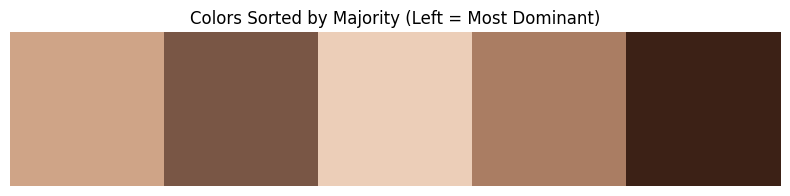

In [37]:
extract_and_show_palette2(r"C:\Users\User\OneDrive\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\data\runway\babayo\babayo_33.jpg", n_colors=5)

In [206]:
def process_all_colours(main_folder_path, output_csv_path):
    all_brand_data = []

    # Load the pre-trained DeepLabV3 model for segmentation
    model2 = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights='DEFAULT')
    model2.eval()

    preprocess = transforms.Compose([
    transforms.Resize((520,520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    for brand_name in os.listdir(main_folder_path):
        brand_folder = os.path.join(main_folder_path, brand_name)
        
        if not os.path.isdir(brand_folder):
            continue

        print(f"Processing brand: {brand_name}")
        good_img = [ f for f in os.listdir(brand_folder) if f.lower().endswith(('.jpg','.jpeg', '.png'))]


        for img_name in good_img:
            img_path = os.path.join(brand_folder, img_name)

            try:
                # load and preprocess the image
                input_image = Image.open(img_path).convert("RGB")
                input_tensor = preprocess(input_image).unsqueeze(0) # Add batch dimension

                with torch.no_grad():
                    outputs = model2(input_tensor)['out'][0]
                    
                mask = torch.argmax(outputs, dim=0).cpu().numpy()                
                garment_masks = (mask == 15) #15 is for a person in the model
                
                # convert OG image to LAB for colour analysis
                mask_img = input_image.resize((520, 520))
                img_np = np.array(mask_img)
                img_lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)      
                pixels = img_lab[garment_masks]

                if len(pixels) > 0:
                    # kmeans to find dominant colours
                    n = 5
                    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
                    kmeans.fit(pixels)
                    
                    found_colours = [get_colour_name(centroid) for centroid in kmeans.cluster_centers_]
                    unique_names = list(set(found_colours))

                    # if "Black" in unique_names and len(unique_names) > 1:
                    #     unique_names.remove("Black")
                    if "Skin" in unique_names:
                        unique_names.remove("Skin")
                    if "Shadows" in unique_names:
                        unique_names.remove("Shadows")
                    if "BG" in unique_names:
                        unique_names.remove("BG")
                    if "Highlights" in unique_names:
                        unique_names.remove("Highlights")
                    # if "Grey" in unique_names:
                    #     unique_names.remove("Grey")
                    

                    if unique_names and len(unique_names) > 0:
                        all_brand_data.append({
                            "brand": brand_name,
                            "image": img_name,
                            "colours": ", ".join(unique_names)})
                
                
            except Exception as e:
                print(f"skipping {img_name} due to error: {e}")
        df = pd.DataFrame(all_brand_data)
        df.to_csv(output_csv_path, index=False)        
        print(f"Segmentation completed for {brand_name}.\n")

    df = pd.DataFrame(all_brand_data)
    df.to_csv(output_csv_path, index=False)
    print("Colour analysis completed and saved to CSV.")

    return all_brand_data

In [207]:
main_folder_path = r'C:\Users\User\OneDrive\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\data\runway'
output_csv_path = r'C:\Users\User\OneDrive\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\outputs\runway_colours.csv'

extracted_colours = process_all_colours(main_folder_path, output_csv_path)

Processing brand: adage_studio_project_x_unrefyned
Segmentation completed for adage_studio_project_x_unrefyned.

Processing brand: adama_paris
Segmentation completed for adama_paris.

Processing brand: ajabeng
Segmentation completed for ajabeng.

Processing brand: ajanee
Segmentation completed for ajanee.

Processing brand: babayo
Segmentation completed for babayo.

Processing brand: bloke
Segmentation completed for bloke.

Processing brand: boyedoe
Segmentation completed for boyedoe.

Processing brand: cute_saint
Segmentation completed for cute_saint.

Processing brand: cynthia_abila
Segmentation completed for cynthia_abila.

Processing brand: desiree_iyama
Segmentation completed for desiree_iyama.

Processing brand: dimeji_ilori
Segmentation completed for dimeji_ilori.

Processing brand: eki_silk
Segmentation completed for eki_silk.

Processing brand: elexiay
Segmentation completed for elexiay.

Processing brand: emmy_kasbit
Segmentation completed for emmy_kasbit.

Processing brand: 

In [20]:
import cv2
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def visualize_segmentation(image_path):
    # 1. Load the Model (DeepLabV3)
    # We load it here just for the visualization check
    model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights='DEFAULT')
    model.eval()

    # 2. Preprocess the Image
    preprocess = transforms.Compose([
        transforms.Resize((520, 520)), # DeepLab expects specific size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    try:
        input_image = Image.open(image_path).convert("RGB")
    except:
        print(f"Error: Could not open image at {image_path}")
        return

    # 3. Generate the Mask
    input_tensor = preprocess(input_image).unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)['out'][0]
    
    # Get the segmentation map (15 is the class for 'Person')
    output_predictions = output.argmax(0).byte().cpu().numpy()
    mask = (output_predictions == 15).astype(np.uint8)

    # 4. Prepare Images for Display
    # Resize original image to match the mask (520x520) so we can overlay them
    resized_image = input_image.resize((520, 520))
    image_np = np.array(resized_image)
    
    # Create the "Person Only" view
    # We multiply by the mask to black out the background
    person_only = cv2.bitwise_and(image_np, image_np, mask=mask)

    # 5. Plotting
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image (Resized)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Segmentation Mask (White = Person)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(person_only)
    plt.title("Pixels Used for Colour Analysis")
    plt.axis('off')

    plt.show()

# --- RUN IT ---
# Replace this path with the actual path to one of your images

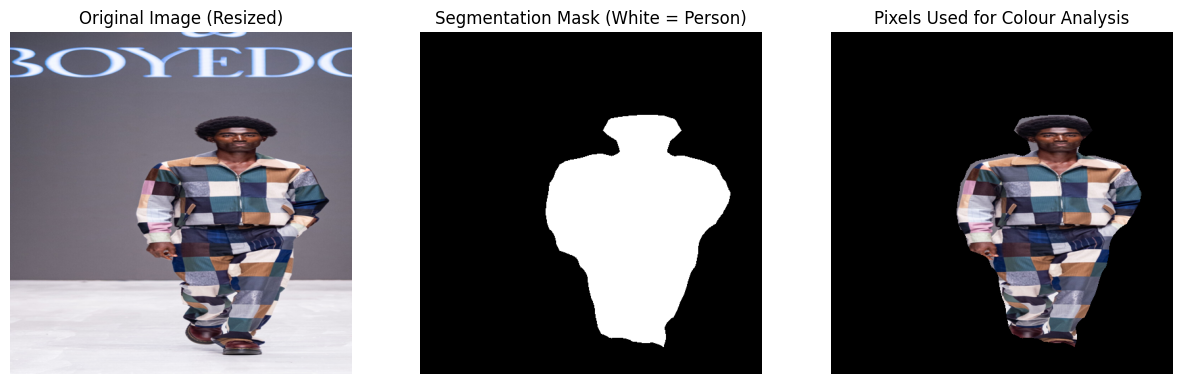

In [133]:
visualize_segmentation(r"C:\Users\User\OneDrive\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\data\runway\boyedoe\boyedoe_18.jpg")

OVERALL FREQUENCY OF COLOURS

In [208]:
colour_present = []

for entry in extracted_colours:
    # split by comma because we saved them as a string in the CSV format
    names = entry['colours'].split(", ")
    colour_present.extend(names)

# 2. Count and Sort
colour_count = Counter(colour_present)
sorted_colours = dict(sorted(colour_count.items(), key=lambda item: item[1], reverse=True))

# 3. Prepare for Plotting
names = list(sorted_colours.keys())
counts = list(sorted_colours.values())
total_colours = sum(counts)
percentages = [(count / total_colours) * 100 for count in counts]

# Print the top 5 colors for a quick check
print("Top 5 Colours across the entire runway:")
for i in range(5):
    print(f"{names[i]}: {counts[i]} garments ({percentages[i]:.2f}%)")

Top 5 Colours across the entire runway:
Grey: 310 garments (14.41%)
Cream/Khaki/Beige: 295 garments (13.71%)
Blue: 229 garments (10.64%)
Pink: 212 garments (9.85%)
White: 204 garments (9.48%)


VISUALIZATION

In [209]:
df1 = pd.read_csv(output_csv_path)
all_colour_names =[]
for val in df1['colours'].dropna():
    names = val.split(", ")
    all_colour_names.extend(names)
    

plot_colours = [name_to_lab(colour) for colour in names]

NameError: name 'name_to_lab' is not defined

WHOLE RUNWAY STATS

NameError: name 'plot_colours' is not defined

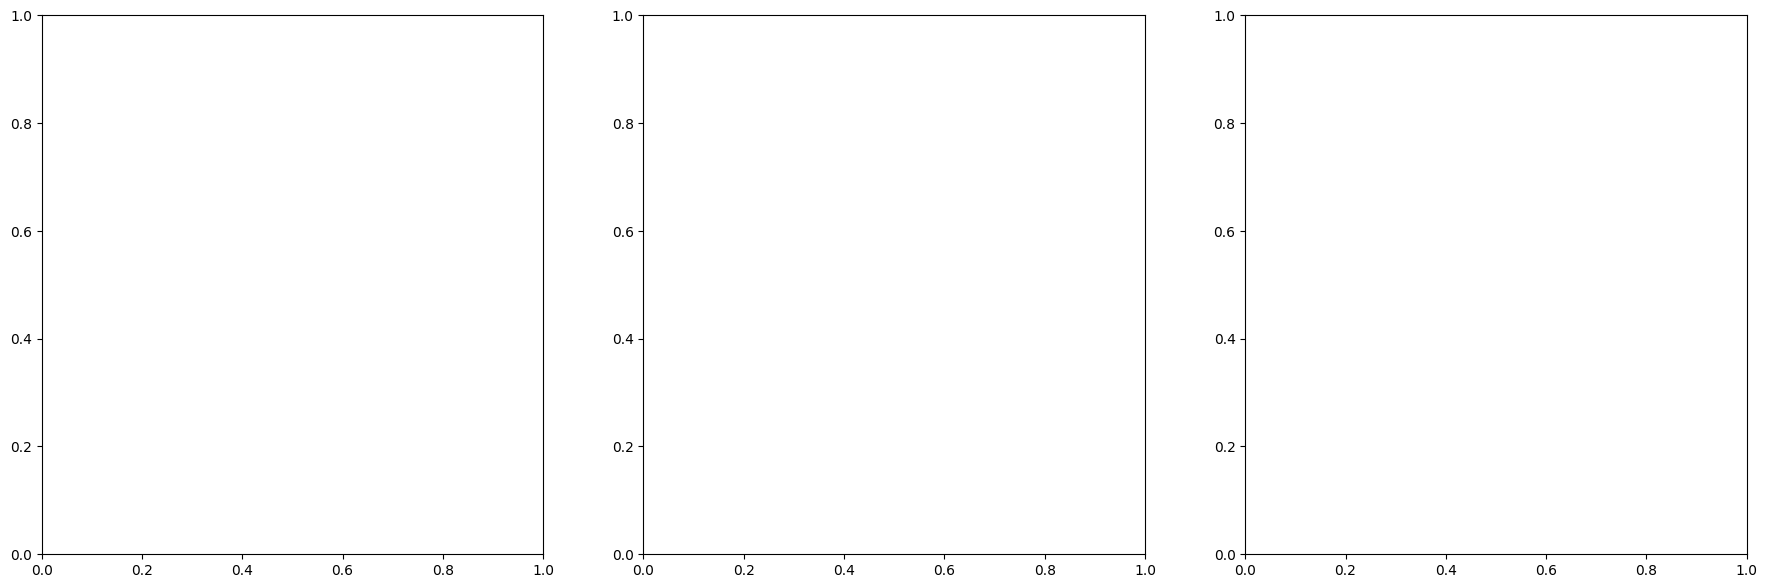

: 

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(22, 7))
# A. Bar Chart: Frequency 
axes[0].bar(names, counts, color=plot_colours, edgecolor='black')
axes[0].set_title('Color Frequency: LFW 25 Runway', fontsize=14)
axes[0].set_ylabel('Number of Occurrences')
axes[0].tick_params(axis='x', rotation=45)

plt.tight_layout()
freq_img_path = r'C:\Users\User\OneDrive\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\outputs\stats\overall_colour_frequency.png'
plt.savefig(freq_img_path, dpi=300)
print(f"Visualization report saved to: {freq_img_path}")


In [28]:
# B. Percentage Chart: Distribution
axes[1].pie(percentages, labels=names, autopct='%1.1f%%', 
            colors=plot_colours, startangle=140, wedgeprops={'edgecolor': 'black'})
axes[1].set_title('Overall Color Distribution (%)', fontsize=14)

plt.tight_layout()
dist_img_path = r'C:\Users\User\OneDrive\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\outputs\stats\overall_colour_distribution.png'
plt.savefig(dist_img_path, dpi=300)
print(f"Visualization report saved to: {dist_img_path}")
plt.show()

ValueError: 'labels' must be of length 'x', not 1

In [ ]:
# C. Color Palette: The "Runway Palette"
# We create a simple strip showing the dominant colors in order
palette_img = np.zeros((100, 500, 3))
start = 0
for i, perc in enumerate(percentages):
    end = start + int((perc / 100) * 500)
    palette_img[:, start:end] = plot_colours[i]
    start = end

axes[2].imshow(palette_img)
axes[2].axis('off')
axes[2].set_title('Overall LFW 25 Runway Palette', fontsize=14)

plt.tight_layout()
palette_img_path = r'C:\Users\User\OneDrive\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\outputs\stats\overall_colour_palette.png'
plt.savefig(palette_img_path, dpi=300)
print(f"Visualization report saved to: {palette_img_path}")
plt.show()

BRAND SPECIFIC STATS

In [29]:
output_dir = r'C:\Users\User\OneDrive\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\outputs\stats'
unique_brands = df1['brand'].unique()

for brand in unique_brands:
    brand_data = df1[df1['brand'] == brand]
    brand_colours = []
    
    for val in brand_data['colours'].dropna():
        names = val.split(", ")
        brand_colours.extend(names)
    
    if not brand_colours: 
        continue
    
    brand_colour_count = Counter(brand_colours)
    sorted_brand_colours = dict(sorted(brand_colour_count.items(), key=lambda item: item[1], reverse=True))
    
    names = list(sorted_brand_colours.keys())
    counts = list(sorted_brand_colours.values())
    total_brand_colours = sum(counts)
    percentages = [(count / total_brand_colours) * 100 for count in counts]
    plot_colours = [name_to_lab(colour) for colour in names]

    print(f"\n Processing Brand: {brand}")
    
    # Print the top 5 colors for a quick check
    print(f"\nTop 5 Colours across {brand} runway:")
    for i in range(5):
        print(f"{names[i]} is found in {percentages[i]:.2f}% of {brand}'s collection.")
    
    # 4. Create the Plot
    fig, axes = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle(f"Colour Analysis: {brand.upper()}", fontsize=20, fontweight='bold')

    # A. Bar Chart
    axes[0].bar(names, counts, color=plot_colours, edgecolor='black')
    axes[0].set_title('Frequency of Colours')
    axes[0].tick_params(axis='x', rotation=45)

    # B. Pie Chart
    axes[1].pie(percentages, labels=names, autopct='%1.1f%%', colors=plot_colours, 
                startangle=140, wedgeprops={'edgecolor': 'black'})
    axes[1].set_title('Distribution (%)')

    # C. Color Palette: The "Runway Palette"
    # We create a simple strip showing the dominant colors in order
    palette_img = np.zeros((100, 500, 3))
    start = 0
    for i, perc in enumerate(percentages):
        end = start + int((perc / 100) * 500)
        if i == len(percentages) - 1:  # Ensure the last color fills any remaining space
            end = 500

        palette_img[:, start:end] = plot_colours[i]
        start = end

    axes[2].imshow(palette_img)
    axes[2].axis('off')
    axes[2].set_title('Runway Palette', fontsize=14)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # 5. Save the report
    brand_filename = f"{brand.replace(' ', '_')}_report.png"
    plt.savefig(os.path.join(output_dir, brand_filename), dpi=200)
    plt.close() # Close plot to save memory during loop

print(f"COMPLETED! ALL BRAND STATS ARE SAVED IN: {output_dir}")


 Processing Brand: adage_studio_project_x_unrefyned

Top 5 Colours across adage_studio_project_x_unrefyned runway:
Coffee is found in 31.25% of adage_studio_project_x_unrefyned's collection.
Dusty Pink is found in 18.75% of adage_studio_project_x_unrefyned's collection.
Lavender is found in 18.75% of adage_studio_project_x_unrefyned's collection.
Charcoal is found in 12.50% of adage_studio_project_x_unrefyned's collection.
Light Gray is found in 6.25% of adage_studio_project_x_unrefyned's collection.

 Processing Brand: adama_paris

Top 5 Colours across adama_paris runway:
Coffee is found in 47.50% of adama_paris's collection.
Chocolate Brown is found in 22.50% of adama_paris's collection.
Orange is found in 10.00% of adama_paris's collection.
Terracotta/Rust is found in 7.50% of adama_paris's collection.
Coral is found in 7.50% of adama_paris's collection.

 Processing Brand: ajabeng

Top 5 Colours across ajabeng runway:
Coffee is found in 47.83% of ajabeng's collection.
Lavender is 

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

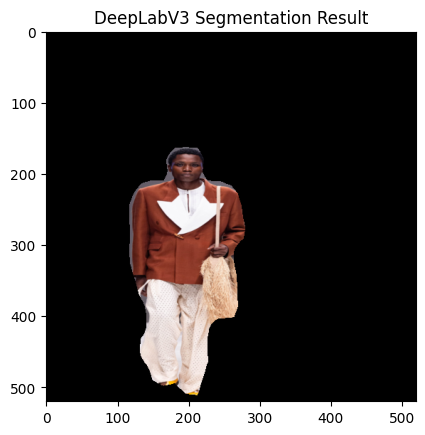

: 

In [ ]:
# Show the result of DeepLabV3 for the first image
plt.imshow(garment_img[10])
plt.title("DeepLabV3 Segmentation Result")
plt.show()

In [ ]:
def visualize_segmentation(image_path):
    # Load original image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get the mask from your existing model
    mask = garment_mask
    
    # Apply the mask to show isolated pixels
    person_only = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Segmentation Mask (White = Detected)")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(person_only)
    plt.title("Pixels used for Colour Analysis")
    plt.axis('off')
    
    plt.show()

# Test it on one of your questionable images
visualize_segmentation("path/to/your/image/boyedoe_6.jpg")